# Liver Model Construction: Notebook-Glycolysis ONLY-trial

## Setup workflow

### Import packages

In [19]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [4]:
seed = int(4)
#increase number of models from before
n_models = 20

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [6]:
#had to remove the mass
model_dir = os.path.abspath("../mass_user/models")
maps_dir = os.path.abspath("../mass_user/maps")
data_dir = os.path.abspath("../mass_user/data")

In [7]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [8]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07fedcbcf5550
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


### View Escher Map

In [9]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=core_model,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

In [10]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    #df = df.drop("Fasting Time", axis=1)
    #df = df.drop("Additional Notes", axis=1)
    #df = df.drop("Flux (mmol/(L*hr))", axis=1)
    #df = df.drop("Name", axis=1)
    return df

In [16]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"1.9-ma-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes")
flux_df = flux_df.drop("Fasting Time", axis=1)
flux_df = flux_df.drop("Additional Notes", axis=1)
# flux_df = flux_df.drop("Flux (mmol/(L*hr))", axis=1)
flux_df = flux_df.drop("Unnamed: 4", axis=1) ## weird anomaly, shouldn't happen
flux_df = flux_df.drop("Unnamed: 5", axis=1)## weird anomaly, shouldn't happen
flux_df


,Flux(mmol/(gDW*hr))
ID,
GLCter,-0.001682
G6PPer,0.001682
G6Pter,0.001682
GLPASE1,0.000223
PGMT,0.000223
EX_glygn2_c,-0.000223
GAPD,-0.000973
PGK,0.000973
PGM,0.002919


In [17]:
v_vars = []
v_data = []

In [20]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0,1000) 
    elif (rid == "EX_glc__L_c"): #secretion
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1000, 0) 
    elif (rid == "EX_pyr_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0, 1000) 
    elif (rid == "EX_glygn2_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1, 1000) 
        
#address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)

GLCter -0.001682007621
G6PPer 0.001682007621
G6Pter 0.001682007621
GLPASE1 0.0002227316028
PGMT 0.0002227316028
EX_glygn2_c -0.0002227316028
GAPD -0.0009728506786666666
PGK 0.0009728506786666666
PGM 0.002918552036
ENO -0.002918552036
PEPCKm 0.00487705406
PCm 0.004685044058
LDH_L 0.002726542034
ME2 0.001950821624
PYK 0.001950821624
CSm 0.002903191236
MDHm 0.003095201238
EX_lac__L_c -0.001758811622
EX_glc__D_c 0.001682007621


In [21]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()

CSm                0.001261
ACONTm             0.000675
ICDHxm             0.000675
AKGDm              0.000675
SUCOASm           -0.000675
                     ...   
EX_nh4_c           0.000000
EX_so3_c          -0.000000
EX_etoh_c         -0.000000
EX_glyc_3octa_c   -0.000000
EX_fru_c           0.000000
Name: fluxes, Length: 187, dtype: float64

In [23]:
# Make adjustments to net flux of PFK/FBP to ensure
# no target flux value is 0 in order to create an enzyme module.
#performing reverse flux percent on computed values rather than measured values like the MASSpy publication
flux_solution.fluxes.FBP = flux_solution.fluxes.PFK * 0.1

0.0009432595435991983

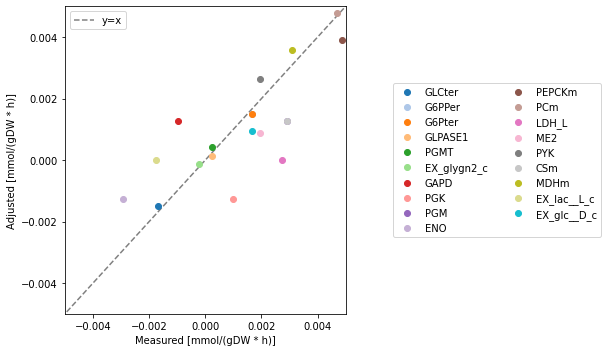

In [24]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux(mmol/(gDW*hr))"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [25]:
glycolysis = MassModel("Glycolysis", array_type='DataFrame', dtype=np.int64)
glycolysis

Name,Glycolysis
Memory address,0x07fedc8ff5290
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [26]:
#add reactions one at a time
reaction_list = ['HEX1',
                ##'PGI',
                ##'FBP',
                #'PFK',
                #'FBA',
                #'TPI',
                #'GAPD',
                #'PGK',
                #'PGM',
                #'ENO',
                ##'PEPtm',
                ##'PEPCKm',
                ##'LDH_L',
                #'PYK'
                ##'PCm',
                ##'PYRt2m'
                ]

In [27]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycolysis.add_reactions([MassReaction(reaction)])

##  Set Fluxes

In [28]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0021779504784422525


## Set Keqs

In [29]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1)

Keq_df
#Check the M units of Keq 

,Equlibrium Constant
Reaction,
CSm,5.225834e-07
ACONTm,7.157880e-02
ICDHxm,1.331211e-01
AKGDm,4.624549e+04
SUCOASm,1.592564e+00
...,...
EX_nh4_c,NaN
EX_so3_c,NaN
EX_etoh_c,NaN


In [30]:
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))

Keq_HEX1: 2246.155176


## Set H2O/H Constants

In [31]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c"
                   #'h_i'
                   #'h_m'
                   #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

## Obtain Concentrations

In [34]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration(M)", axis=1)
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)

In [35]:
conc_df

,Name,Concentration (mM)
ID,,
13dpg_c,"3-Phospho-D-glyceroyl phosphate/ 1,3\nBisphosp...",NaN
2amac_c,2-Aminoacrylate,NaN
2pg_c,D-Glycerate 2-phosphate/ 2-\nPhosphoglycerate,0.110561
3haACP_c,NaN,NaN
3hbcoa_m,NaN,NaN
...,...,...
udp_c,UDP C9H11N2O12P2,0.315888
udpg_c,UDPglucose,0.679781
urea_c,Urea CH4N2O,31.939803


In [36]:
#Set Concentrations

metabolite_list = ['glc__D_c',
           'g6p_c',
           'adp_c',
            'atp_c',
            #'pi_c',
            'h_c']

In [37]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in mM units
        met_list.append(metabolite.ic)

In [38]:
for metabolite in [
    #'h_i',
    #'h_m',
    "h_c", 
    #"h2o_c"
]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    if metabolite.id in ["h_c" 
                         #"h2o_c"
                        ]:
        metabolite.ic = 1000 
for metabolite in glycolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 1.99495195
atp_c: 4.72714598
g6p_c: 0.14
glc__D_c: 10.48280703
h_c: 1000


In [39]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis, # bc only want metabolites in glycolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c", 
        #"h2o_c",'13dpg_c'
    ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycolysis.fixed))
fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
adp_c,1.994952,0.0
atp_c,4.727146,0.0
g6p_c,0.140000,0.0
glc__D_c,10.482807,0.0
Keq_HEX1,2246.155176,0.0


mass/visualization/visualization_util.py:1270 UserWarning: Ignoring {'ru5p__D_c', 'gly_m', 'gtp_m', 'glyc3p_c', 'hxcoa_m', 'glu__L_c', 'orn_c', 'occoa_c', 'pyr_m', 'acetone_c', 'mal__L_c', 'coa_m', 'e4p_c', 'oaa_c', 'ggn_c', 'gdp_m', 'arg__L_c', 'pep_c', 'g3p_c', 'nadp_c', 'dxtrn_c', 'gln__L_c', 'co2_m', 'but2eACP_c', 'h_m', 'urea_c', 'oaa_m', '3oocoa_m', 'thex2eACP_c', 'so3_c', 'succoa_m', 'aacoa_m', '3haACP_c', 'q10_m', 'c8crn_c', 'amp_m', 'ficytC_m', 'octa_cons_c', 'etoh_c', 'oc2coa_m', 'pep_m', '3php_c', 'cys__L_c', 'acald_m', 'amp_c', 'occoa_prod_c', 'ppi_m', 'nh4_m', 'butACP_c', 'hmgcoa_m', 'h_i', 'nadp_m', '3hhexACP_c', 'glygn1_c', 'toct2eACP_c', 'malcoa_c', 'actACP_c', 'asp__L_m', 'glyc3p_1octa_c', 'nadh_m', 'nadph_m', 's7p_c', 'h2o_r', '3sala_c', 'o2_c', 'Tyr_ggn_c', 'malACP_c', 'lac__L_c', 'focytC_m', 'cit_m', 'f1p_c', 'glyc_3octa_c', 'mlthf_m', 'h_c', 'f6p_c', 'adp_m', 'thf_m', 'g6p_r', 'pi_r', '6pgc_c', 'mal__L_m', 'glygn2_c', 'asp__L_c', 'glygn3_c', 'nadph_c', '6pgl_c', 'A

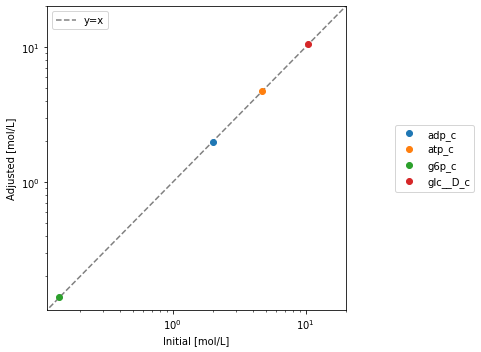

In [41]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (mM)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [42]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c
0,0.458455,3.233446,0.086386,4.534243
1,12.109540,17.797487,0.202197,1.990145
2,2.372755,4.978596,0.261325,27.939262
3,16.889379,2.251416,0.092008,4.773282
4,6.629605,1.070898,0.393049,32.646910


## Set concentrations and balance models with pseudoreactions

In [43]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))
print(models_for_ensemble)

Number of models in ensemble: 20
[<MassModel Glycolysis_C0 at 0x7fedc0413b10>, <MassModel Glycolysis_C1 at 0x7fedcb864650>, <MassModel Glycolysis_C2 at 0x7fedc07fb610>, <MassModel Glycolysis_C3 at 0x7fedc9067350>, <MassModel Glycolysis_C4 at 0x7fedc93b73d0>, <MassModel Glycolysis_C5 at 0x7fedc0376910>, <MassModel Glycolysis_C6 at 0x7fedc037a9d0>, <MassModel Glycolysis_C7 at 0x7fedc02cae10>, <MassModel Glycolysis_C8 at 0x7fedc01f8e90>, <MassModel Glycolysis_C9 at 0x7fedc0173e90>, <MassModel Glycolysis_C10 at 0x7fedc016fd50>, <MassModel Glycolysis_C11 at 0x7fedc00a7390>, <MassModel Glycolysis_C12 at 0x7feda5fb6b10>, <MassModel Glycolysis_C13 at 0x7feda5f6a350>, <MassModel Glycolysis_C14 at 0x7feda5ea5390>, <MassModel Glycolysis_C15 at 0x7feda5efd590>, <MassModel Glycolysis_C16 at 0x7feda5ef6a90>, <MassModel Glycolysis_C17 at 0x7feda5d00050>, <MassModel Glycolysis_C18 at 0x7feda5f535d0>, <MassModel Glycolysis_C19 at 0x7feda5c3c510>]


#### Ensure model is in steady state and export

In [52]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

In [53]:
# glycolysis.calculate_PERCs(update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 0.000044
kf_SK_adp_c: 100000.000000
kf_SK_atp_c: 100000.000000
kf_SK_g6p_c: 100000.000000
kf_SK_glc__D_c: 100000.000000
kf_SK_h_c: 100000.000000


In [54]:
## balancing charges on reactions manually

glycolysis.metabolites.h_c.charge=1

In [55]:
qcqa_model(glycolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycolysis                     │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [58]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

ERROR: Error encountered trying to  <set gene id  for '3098_AT3'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.


MassSimulationError: Could not load MassModel 'Glycolysis_C0'

In [76]:
glycolysis.genes.remove('3098_AT3')

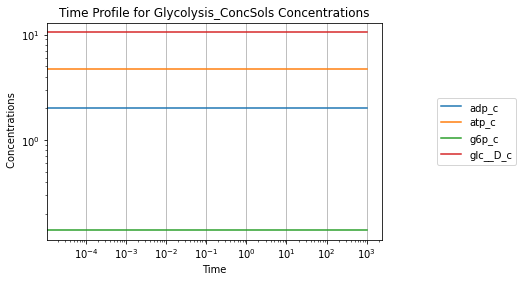

In [77]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

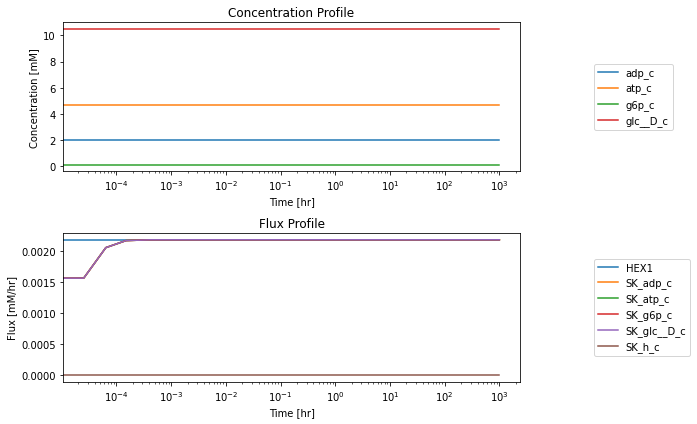

In [81]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

